In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import sys, os
sys.path.insert(1, os.path.abspath('../../Tools'))
from dea_tools.plotting import rgb
from dea_tools.plotting import rgb, display_map
from matplotlib import colors as mcolours
from dea_tools.land_cover import plot_land_cover


In [2]:
dc = datacube.Datacube(app='DEA_Land_Cover')

In [82]:
# Define area of interest and buffer values 
lat, lon = (-37.9, 144.7)

lat_buffer = 0.02
lon_buffer = 0.02

# Combine central coordinates with buffer to get area of intest 
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

# Set the range of dates for the analysis
time_range = ('2010', '2020')

In [83]:
display_map(x=lon_range, y=lat_range)

In [84]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes and time defined above.
query = {
    'y': lat_range,
    'x': lon_range,
    'time': time_range,
}

# Load DEA Land Cover data from the datacube
lc = dc.load(product='ga_ls_landcover_class_cyear_2',
             output_crs='EPSG:3577',
             measurements=['level3'],
             resolution=(25, -25),
             **query)

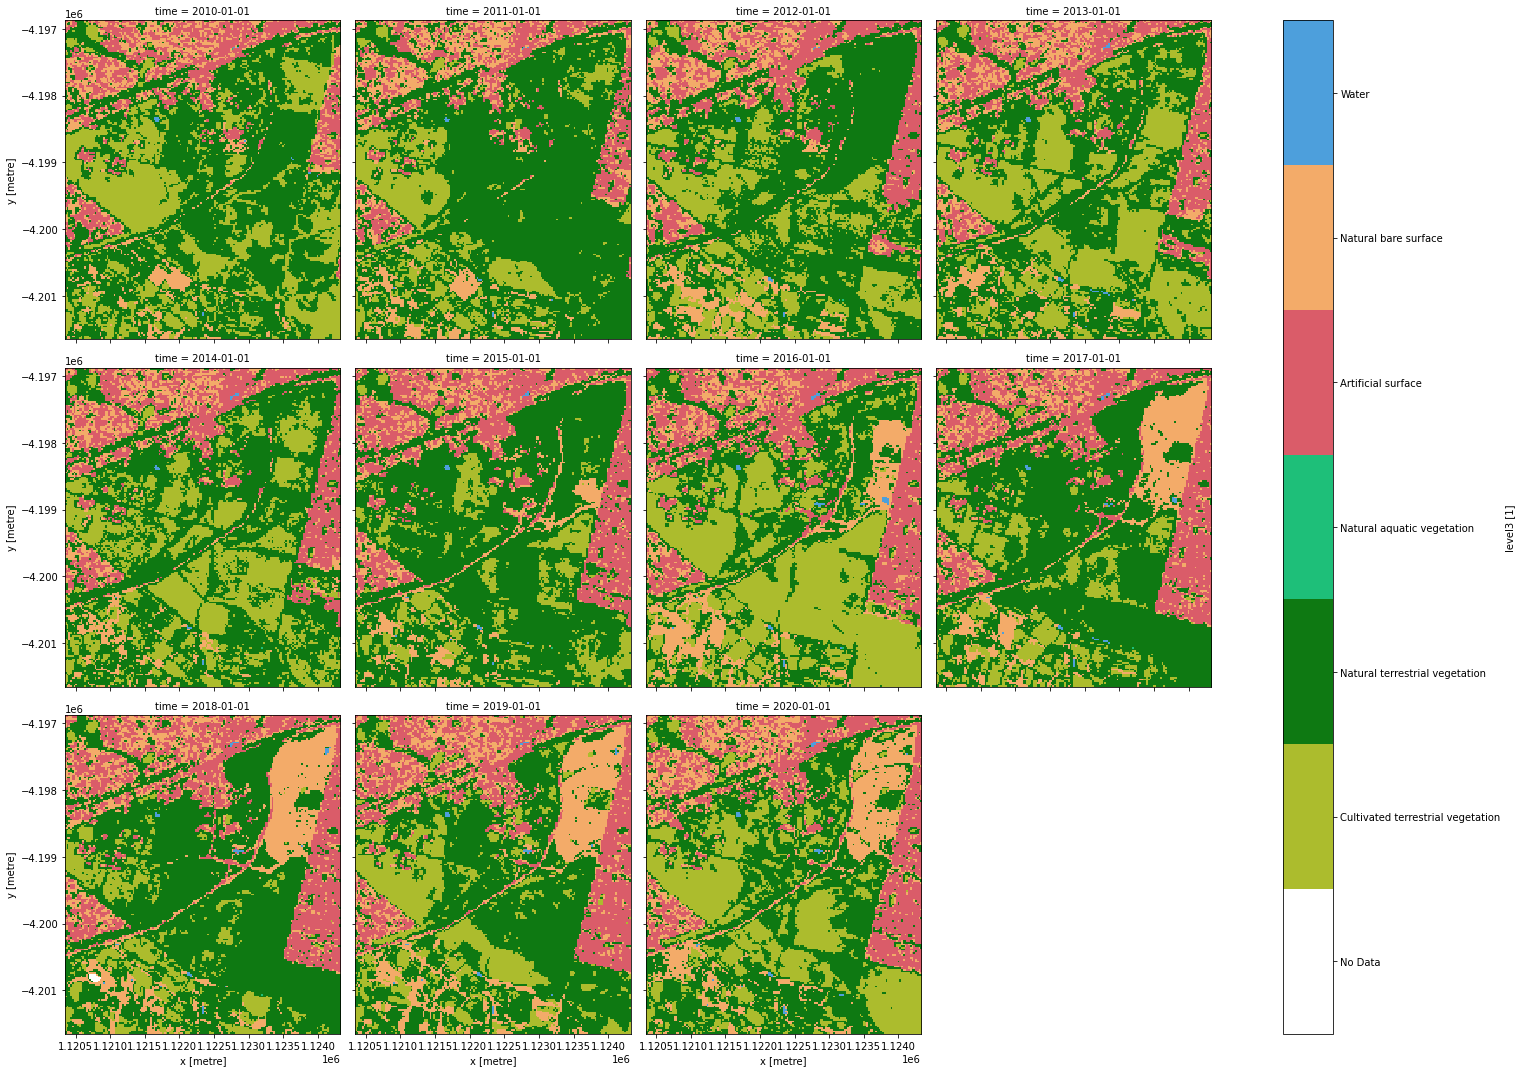

In [85]:
plot_land_cover(lc.level3)

In [86]:
# select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[0].astype(np.int32)
end = lc.level3[-1].astype(np.int32)

# mark if you want to ignore no change
ignore_no_change = True

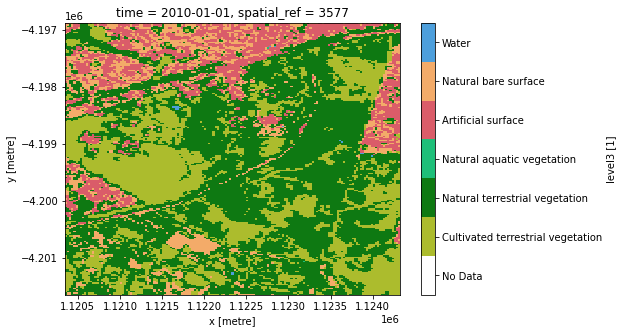

In [87]:
plot_land_cover(start)

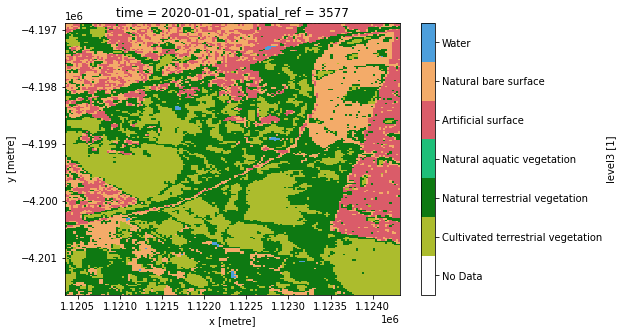

In [88]:
plot_land_cover(end)

#### combine classifications from start & end dates

In [89]:
change_vals = ((start * 1000) + end)

# # Mask out values with no change by setting to 0 if this is requested.
if ignore_no_change:
    out_change = np.where(start == end, 0, change_vals)

In [90]:
out_change

array([[     0,      0,      0, ...,      0,      0,      0],
       [     0,      0,      0, ...,      0, 216112,      0],
       [     0,      0,      0, ...,      0,      0,      0],
       ...,
       [     0, 112216, 216112, ..., 112216, 112216,      0],
       [112215, 216215,      0, ..., 112216,      0,      0],
       [216112, 215112,      0, ...,      0, 215216,      0]], dtype=int32)

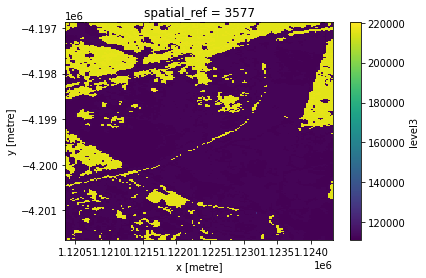

In [92]:
change_vals.plot()

### find changes of interest

##### Natural terrestrial vegetation change

In [93]:
# make a mask of 1 for all increasing natural terrestrial vegetation (NTV)
# that is anything going from another class to NTV
NTV_increase = np.where(((out_change == 111112) |
                                (out_change == 124112) |
                                (out_change == 215112) |
                                (out_change == 216112) |
                                (out_change == 220112)),
                               1, 0)

In [95]:
# make a mask of -1 for all decreasing natural terrestrial vegetation (NTV)
# that is anything going from NTV to another class
NTV_decrease = np.where(((out_change == 112111) |
                                (out_change == 112124) |
                                (out_change == 112215) |
                                (out_change == 112216) |
                                (out_change == 112220)),
                               -1, 0)

In [96]:
NTV_change = NTV_increase + NTV_decrease

In [98]:
# create a new Xarray.DataArray, so we can plot
xr_ntvchange = xr.DataArray(data=NTV_change, 
             coords=change_vals.coords, 
             dims=change_vals.dims, name="ntv_change", 
             attrs=None, indexes=change_vals.indexes, fastpath=False)

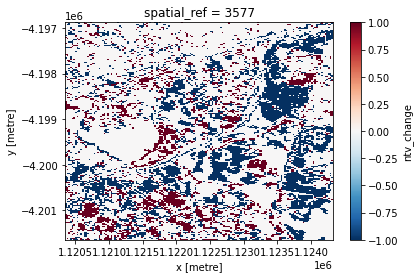

In [99]:
xr_ntvchange.plot.imshow()

##### Urban expansion

In [100]:
# make a mask of 1 for all increasing artificial surfaces (AS)
AS_increase = np.where(((out_change == 111215) |
                                (out_change == 112215) |
                                (out_change == 124215) |
                                (out_change == 216215) |
                                (out_change == 220215)),
                               1, 0)

In [101]:
# make a mask of -1 for all decreasing artificial surfaces (AS)
AS_decrease = np.where(((out_change == 215111) |
                                (out_change == 215112) |
                                (out_change == 215124) |
                                (out_change == 215216) |
                                (out_change == 215220)),
                               -1, 0)

In [102]:
AS_change = AS_increase + AS_decrease

In [103]:
# create a new Xarray.DataArray, so we can plot
xr_aschange = xr.DataArray(data=AS_change, 
             coords=change_vals.coords, 
             dims=change_vals.dims, name="as_change", 
             attrs=None, indexes=change_vals.indexes, fastpath=False)

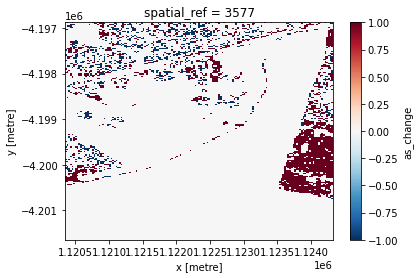

In [104]:
xr_aschange.plot.imshow()

take both lists
take the first list in both lists
compare the ith element in each list 
    if water and water, add 0 to temp list
    if X to water, add 1 to temp list
    if water to X, add -1 to temp list
    go to next element in list 
    when done, add temp list to results list 

In [14]:
array1 = lc.level3[0]
array2 = lc.level3[1]

In [15]:
array1

<xarray.DataArray 'level3' (y: 475, x: 397)>
array([[220, 220, 220, ..., 111, 111, 111],
       [220, 220, 220, ..., 111, 111, 111],
       [220, 220, 220, ..., 111, 111, 111],
       ...,
       [111, 111, 111, ..., 111, 111, 111],
       [111, 111, 111, ..., 111, 111, 111],
       [111, 111, 111, ..., 111, 111, 112]], dtype=uint8)
Coordinates:
    time         datetime64[ns] 2010-01-01
  * y            (y) float64 -4.205e+06 -4.205e+06 ... -4.193e+06 -4.193e+06
  * x            (x) float64 1.127e+06 1.127e+06 ... 1.117e+06 1.117e+06
    spatial_ref  int32 3577
Attributes:
    units:         1
    nodata:        0
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [16]:
array2

<xarray.DataArray 'level3' (y: 475, x: 397)>
array([[220, 220, 220, ..., 111, 111, 111],
       [220, 220, 220, ..., 111, 111, 111],
       [220, 220, 220, ..., 111, 111, 112],
       ...,
       [112, 112, 112, ..., 112, 112, 112],
       [112, 112, 112, ..., 112, 112, 112],
       [112, 112, 112, ..., 112, 112, 112]], dtype=uint8)
Coordinates:
    time         datetime64[ns] 2011-01-01
  * y            (y) float64 -4.205e+06 -4.205e+06 ... -4.193e+06 -4.193e+06
  * x            (x) float64 1.127e+06 1.127e+06 ... 1.117e+06 1.117e+06
    spatial_ref  int32 3577
Attributes:
    units:         1
    nodata:        0
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [17]:
# water is 220
# bare is 216

def test_data(num1, num2):
    # water and water
    if num1 == num2:
        return 0
    # water to bare
    elif num1 == 220 and num2 != 220:
        return -1
    # bare to water 
    elif num1 != 220 and num2 == 220:
        return 1
    else:
        return 5

In [18]:
test_data(array1[0][0], array2[0][0])

0

In [19]:
array_len = len(array1)
array_len

475

In [20]:
list_len = len(array1[0])
list_len

397

In [21]:
change_mapping_results = []

i = 0

while i < array_len:
    year1 = array1[i]
    year2 = array2[i]
    
#     print("Current lists being compared", array1[i], array2[i])
#     print("---------------------------------------------------------")
        
    j = 0
    temp_change_value_list = []
    
    while j < list_len:
#         print("current value for array1", array1[i][j])
#         print("current value for array2", array2[i][j])
#         print("---------------------------------------------------------")

        temp_change_value = test_data(array1[i][j], array2[i][j])
        temp_change_value_list.append(temp_change_value)        

        j = j + 1
    
    print(temp_change_value_list)

    i = i + 1



[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 5, 5, 5, 5, 5, 5, 0, 5, 0, 0, 0, 0, 0, 0, 5, 5, 0, 5, 5, 5, 5, 0, 0, 5, 0, 0, 5, 0, 5, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 0, 0, 0, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 0, 0, 0, 5, 0, 5, 5, 0, 0, 0, 5, 0, 5, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 5, 5, 5, 0, 5, 5, 0, 5, 5, 5, 5, 0, 5, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 0, 0, 0, 5, 5, 5, 0, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 0, 0, 5, 5, 0, 0, 0, 0, 5, 0, 

In [22]:
test_solution = np.array([[0, 0], [-1, 0], [-1, -1], [-1, -1]])

In [23]:
TEST_SCHEME = { 0  : (255, 255, 255, 255, "No change"),
                1  : (172, 188, 45, 255, "Bare to water"),
                -1 : (14, 121, 18, 255, "Water to bare"),
                5  : (30, 191, 121, 255, "N/A")}

In [24]:
array_x = array1

In [25]:
array_x.data = test_solution

ValueError: replacement data must match the Variable's shape. replacement data has shape (4, 2); Variable has shape (475, 397)

In [ ]:
array_x